In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


%cd /content/drive/MyDrive/DL2
!unzip '/content/drive/MyDrive/DL2/train_hands.zip'

In [ ]:
%cd /content/drive/MyDrive/DL2

/content/drive/MyDrive/DL2


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
from PIL import Image
import os
import imageio
import csv
import pandas as pd
import cv2
device ='cpu'

In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


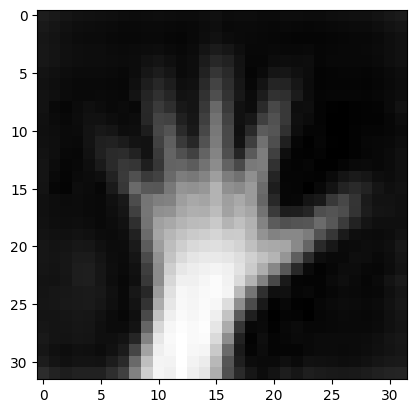

In [ ]:
image1 =cv2.imread('/content/drive/MyDrive/DL2/train_hands/VAE_hand_361.jpeg')
from matplotlib import pyplot as plt
plt.imshow(image1, cmap='Greys')

Here I am creating files with the label data for each filename

In [ ]:
GANlabel= []
for filename in os.listdir('/content/drive/MyDrive/DL2/GAN_hands'):
          img = filename
          GANlabel.append((img,2))

csv_file_name = 'GAN_labels.csv'
with open(csv_file_name, 'w', newline='') as csv_file:
  csv_writer = csv.writer(csv_file)
  for tuple_pair in GANlabel:
        csv_writer.writerow(tuple_pair)

In [ ]:
VAElabel= []
for filename in os.listdir('/content/drive/MyDrive/DL2/VAE_hands'):
          img = filename
          VAElabel.append((img,1))

csv_file_name = 'VAE_labels.csv'
with open(csv_file_name, 'w', newline='') as csv_file:
  csv_writer = csv.writer(csv_file)
  for tuple_pair in VAElabel:
        csv_writer.writerow(tuple_pair)

In [ ]:
reallabel= []
for filename in os.listdir('/content/drive/MyDrive/DL2/real_hands'):
          img = filename
          VAElabel.append((img,0))

csv_file_name = 'real_labels.csv'
with open(csv_file_name, 'w', newline='') as csv_file:
  csv_writer = csv.writer(csv_file)
  for tuple_pair in reallabel:
        csv_writer.writerow(tuple_pair)

In [ ]:
labels=[]
for filename in os.listdir('/content/drive/MyDrive/DL2/real_hands'):
          img = filename
          labels.append((img,0))
for filename2 in os.listdir('/content/drive/MyDrive/DL2/GAN_hands'):
          img2 = filename2
          labels.append((img2,2))
for filename1 in os.listdir('/content/drive/MyDrive/DL2/VAE_hands'):
          img1 = filename1
          labels.append((img1,1))
csv_file_name = 'train_label.csv'
with open(csv_file_name, 'w', newline='') as csv_file:
  csv_writer = csv.writer(csv_file)
  for tuple_pair in labels:
        csv_writer.writerow(tuple_pair)

creating a transform for my data

In [132]:

transform =transforms.Compose([transforms.ToTensor(),transforms.Resize((32,32)),transforms.Normalize(mean=(0.5),std=(0.5)),transforms.Grayscale()])

In [133]:
class CustomDataset(Dataset):
    def __init__(self,label_file, folder_path, transform=None,target_transform=None):
        self.folder_path = folder_path
        self.img_labels =pd.read_csv(label_file)
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self,idx):
        img_path = os.path.join(self.folder_path, self.img_labels.iloc[idx, 0])
        try:
            # Try to load the image using PIL
            image = Image.open(img_path)


            # Convert the image to grayscale if it has multiple channels
            if image.mode != 'L':
                image = image.convert('L')

        except Exception as e:
            # Handle any exceptions (e.g., FileNotFoundError, PIL.UnidentifiedImageError)
            print(f"Error loading image at path {img_path}: {e}")
            return None, None  # You can decide what to return in case of an error

        label = self.img_labels.iloc[idx, 1]

        if self.transform and image is not None:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

firstly, create a custom data loader with the images from the GAN,VAE and real file and assign each image a label, so this can be used as the training dataset

In [134]:
label_file ='/content/drive/MyDrive/DL2/train_label.csv'
folder_path ='/content/drive/MyDrive/DL2/train_hands'
train_data =CustomDataset(label_file,folder_path,transform=transform)
labels = train_data.img_labels.iloc[:, 1].to_numpy()

In [ ]:
sample_loader =DataLoader(dataset =train_data,batch_size=64,shuffle=True)
X, y =next(iter(sample_loader))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


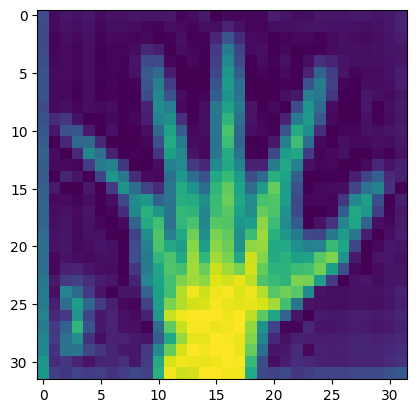

In [ ]:
plt.imshow(X[3].squeeze())

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
indices = next(sss.split(labels, labels))
train_dataset = Subset(train_data, indices[0])
val_dataset = Subset(train_data, indices[1])

In [ ]:
train_sample =DataLoader(dataset =train_dataset,batch_size=64,shuffle=True)
val_sample =DataLoader(dataset =val_dataset,batch_size=64,shuffle=False)

In [ ]:
X, y=next(iter(train_sample))

tensor(1)


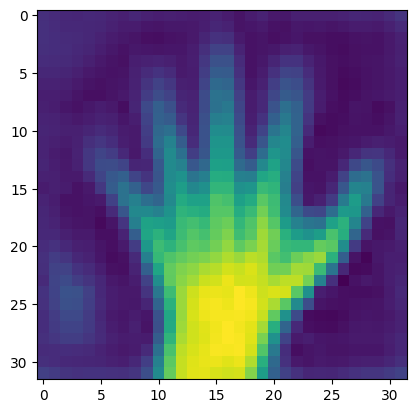

In [ ]:
plt.imshow(X[7].squeeze())
print(y[7])

In [ ]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1) # define a 2D convolutional layer
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # new 2D convolutional layer
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
    self.c5 = nn.Linear(16*5*5, 120)                              # first linear layer
    self.f6 = nn.Linear(120, 84)                                  # second linear layer
    self.output = nn.Linear(84, 3)                               # final output layer
    self.act = nn.ReLU()

  def forward(self, x):
    x = self.act(self.c1(x))                                      # activate pass through the first layer
    x = self.act(self.s2(x))                                      # activate pass through the second layer
    x = self.act(self.c3(x))                                      # activate pass through the third layer
    x = self.act(self.s4(x))                                      # activate pass through the fourth layer
    x=x.view(-1, x.size(1)*x.size(2)*x.size(3))
    print(x.size)
    x = self.act(self.c5(x))                                      # activate pass through fifth layer
    x = self.act(self.f6(x))                                      # activate pass through last layer

    return self.output(x)
x = torch.randn((1, 1, 32, 32))
model = LeNet5()
y = model(x)
print(y)
print(model)

<built-in method size of Tensor object at 0x7e6460c44e50>
tensor([[-0.1117,  0.0467, -0.0334]], grad_fn=<AddmmBackward0>)
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=3, bias=True)
  (act): ReLU()
)


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
model =AlexNet()
x = torch.randn((1, 1, 32, 32))
model = AlexNet()
y = model(x)
print(y)
print(model)

tensor([[-0.0335, -0.0329,  0.0659]], grad_fn=<AddmmBackward0>)
AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6400, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout

In [ ]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 64
n_epochs = 100

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [ ]:
!ls train_hands | wc -l

1444


In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0

    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      a2 = model(X.view(-1, 1, 32, 32))


      loss = criterion(a2, y)
      loss.backward()
      train_loss += loss*X.size(0)
      y_pred = F.log_softmax(a2, dim=1).max(1)[1]
      train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
      optimizer.step()
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 32, 32))

            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 32, 32))

            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

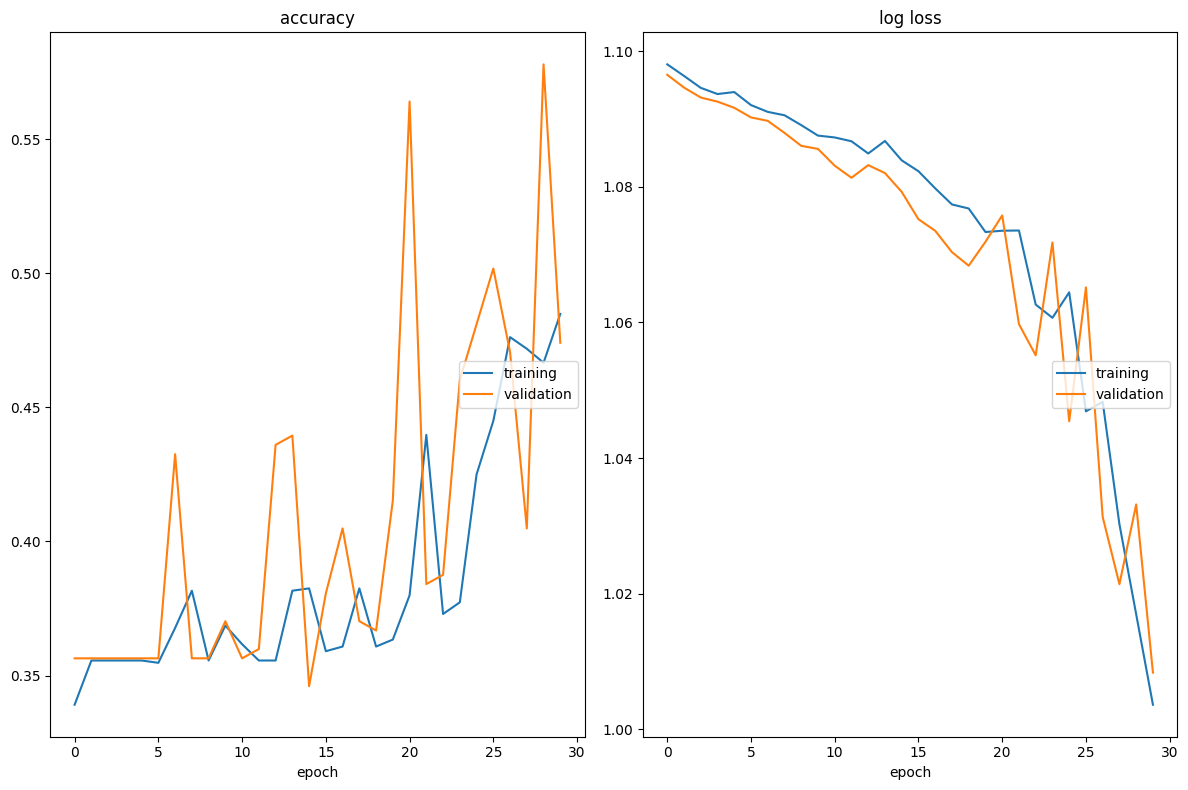

accuracy
	training         	 (min:    0.339, max:    0.485, cur:    0.485)
	validation       	 (min:    0.346, max:    0.578, cur:    0.474)
log loss
	training         	 (min:    1.004, max:    1.098, cur:    1.004)
	validation       	 (min:    1.008, max:    1.097, cur:    1.008)


In [ ]:
def train_model(momentum):
  set_seed(seed)
  model = AlexNet().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  train_sample =DataLoader(dataset =train_dataset, batch_size=64, shuffle=True, num_workers=0)
  val_sample =DataLoader(dataset =val_dataset, batch_size=64, shuffle=False, num_workers=0)


  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_sample)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, val_sample)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

  return model

model = train_model(0.5)

In [ ]:
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0) # create a validation_loader
y_pred, y_gt = evaluate(model, validation_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


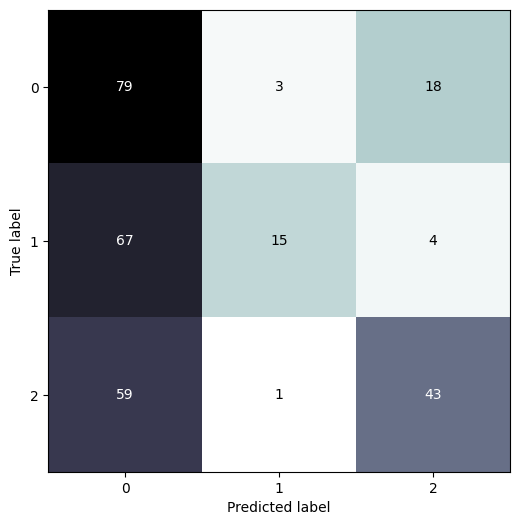

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_gt, y_pred, ax=ax, colorbar=False, cmap='bone_r')
plt.show()

In [ ]:
test_data =[]
img_data =[]
for filename in os.listdir('/content/drive/MyDrive/DL2/test_hands'):
  img =cv2.imread(f'/content/drive/MyDrive/DL2/test_hands/{filename}')
  name =filename
  test_data.append((img, filename))
  img_data.append(img)
test_dict =(test_data)

In [ ]:
CustomDataset()

In [71]:
!rm test_hands/test_hand_3551.jpeg

In [135]:
transform =transforms.Compose([transforms.ToTensor(),transforms.Resize((32,32)),transforms.Normalize(mean=(0.5),std=(0.5)),transforms.Grayscale()])

In [149]:
class TestDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform

        images= []
        file_name =[]
        for filename in os.listdir(self.folder_path):
          img = imageio.imread(os.path.join(folder_path, filename))
          images.append(img)
          file_name.append(filename)

        self.data =images
        self.file_name =file_name

    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = self.transform(sample)
        return sample, self.file_name

        try:
            # Try to load the image using PIL
            image = Image.open(img_path)


            # Convert the image to grayscale if it has multiple channels
            if image.mode != 'L':
                image = image.convert('L')

        except Exception as e:
            # Handle any exceptions (e.g., FileNotFoundError, PIL.UnidentifiedImageError)
            print(f"Error loading image at path {img_path}: {e}")
            return None, None  # You can decide what to return in case of an error


        if self.transform and image is not None:
            image = self.transform(image)


    def __len__(self):
      return len(self.data)

In [150]:
folder_path ='/content/drive/MyDrive/DL2/test_hands'
test_dataset =TestDataset(folder_path=folder_path,transform=transform)

<ipython-input-149-2fe937c5640c>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(os.path.join(folder_path, filename))


In [151]:
test_loader=DataLoader(dataset =test_dataset,batch_size=200,shuffle=True)

In [111]:
y,v =next(iter(test_loader))
v

('test_hand_5535.jpeg',)

In [152]:
def evaluate(model, data_loader):
    model.eval()
    y_preds = []
    for X, v in data_loader:
        with torch.no_grad():
            X = X.to(device)
            a2 = model(X.view(-1, 1, 32, 32))

            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0), v

In [153]:
y,filename =evaluate(model=model, data_loader=test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [162]:
final =zip(filename,y)
csv_file_name = 'iyc23_classified_hands.csv'
with open(csv_file_name, 'w', newline='') as csv_file:
  csv_writer = csv.writer(csv_file)
  for tuple_pair in final:
        csv_writer.writerow(tuple_pair)

In [85]:
!pwd

/content/drive/MyDrive/DL2


In [120]:
!ls test_hands | wc -l

5729
